In [1]:
# Feed each chunk into neural network
# Feed acc (x,y,z,mag) + gyr (x,y,z,mag)

In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchsummary import summary
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm

In [2]:
import sys
sys.path.append("../gaitkeeper")
from load import IDNET_PATH, get_reference_data
from preprocess import generate_walk_chunks, normalize_sensor_data

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import random
SEED = 111
random.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)

### load all walk data

In [5]:
# Get number of walks per user
counts = {}
for folder in IDNET_PATH.glob("*"):
    user_id = int(folder.stem[1:4])
    if user_id not in counts:
        counts[user_id] = 1
    else:
        counts[user_id] += 1
users_with_multiple_walks = [user for user, count in counts.items() if count > 1]

In [6]:
dfs = []
for folder in tqdm(list(IDNET_PATH.glob("*"))):
    user_id = int(folder.stem[1:4])
    walk_id = int(folder.stem[6:9])
    if (user_id not in users_with_multiple_walks) or walk_id > 2:
        continue  # Limit dataset to 2 walks for individuals with more than 1 walk
    df = get_reference_data(user_id, walk_id).reset_index()
    df.insert(0, "walk_id", walk_id)
    df.insert(0, "user_id", user_id)
    dfs.append(df)
df = pd.concat(dfs)

In [9]:
# split into chunks
# note don't need training/validation because autoencoder
chunks = []
for (user_id, walk_id), subdf in df.groupby(["user_id", "walk_id"]):
    chunks.extend(list(generate_walk_chunks(subdf, chunksize=256, window_step = 256//2)))

In [10]:
user_labels = [chunk["user_id"].iloc[0] for chunk in chunks]

In [11]:
uid_sample_counts = pd.Series(user_labels).value_counts().sort_index().to_dict()
class_weights = 1/np.array(list(uid_sample_counts.values()))*1000
class_weights

array([ 4.65116279,  2.08333333,  1.85185185,  2.7027027 ,  2.3364486 ,
        4.03225806,  3.22580645,  1.54559505,  2.21238938,  2.68817204,
        4.95049505,  3.21543408,  3.84615385,  4.03225806,  3.47222222,
        2.51889169,  3.81679389,  2.07900208,  7.14285714,  3.47222222,
        4.03225806,  2.34741784,  2.53164557,  3.63636364, 52.63157895,
        3.92156863,  3.77358491,  5.29100529,  3.84615385])

In [12]:
# user id to class label (0-indexed, non-skipping)
uid_to_clss = {user_id: i for i, user_id in enumerate(np.unique(user_labels))}
uid_to_clss 

{1: 0,
 2: 1,
 3: 2,
 4: 3,
 7: 4,
 10: 5,
 16: 6,
 18: 7,
 19: 8,
 20: 9,
 21: 10,
 23: 11,
 24: 12,
 25: 13,
 26: 14,
 27: 15,
 28: 16,
 29: 17,
 30: 18,
 31: 19,
 33: 20,
 34: 21,
 35: 22,
 36: 23,
 37: 24,
 38: 25,
 40: 26,
 43: 27,
 46: 28}

In [13]:
train, test, train_labels, test_labels = train_test_split(chunks, user_labels, test_size=0.1, shuffle=True, stratify=user_labels)

In [14]:
assert len(np.unique(train_labels)) == len(np.unique(user_labels))  # test stratified
n_classes = len(np.unique(user_labels))

In [64]:
# why CNN - translational invariance!

class AutoEncoder(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        # Input to conv1d needs to be (batch_size, channels, signal_length)
        # try downsampling?
        # encoder
        self.encoder = nn.Sequential(*[
            nn.Conv1d(2, 8, 3, padding=1, padding_mode="replicate"), nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(8, 12, 3, padding=1, padding_mode="replicate"), nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(12, 24, 3, padding=1, padding_mode="replicate"), nn.ReLU(),
            nn.MaxPool1d(2), # Embedding sohuld span negative values (Tanh vs. ReLU/Sigmoid)
            nn.Flatten()
        ])
        self.fc1 = nn.Sequential(*[
            nn.Linear(in_features=24 * 32, out_features=20), nn.ReLU()
        ]) # embedding
        self.fc2 = nn.Sequential(*[
            nn.Linear(in_features=20, out_features=n_classes)  # no softmax - use crossentropyloss
        ])
        
    def forward(self, x):
        encoder = self.encoder(x)
        embedding = self.fc1(encoder)
        classification = self.fc2(embedding)
        return classification, embedding

In [65]:
model = AutoEncoder(n_classes).to(DEVICE)

In [66]:
summary(model, (2, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 8, 256]              56
              ReLU-2               [-1, 8, 256]               0
         MaxPool1d-3               [-1, 8, 128]               0
            Conv1d-4              [-1, 12, 128]             300
              ReLU-5              [-1, 12, 128]               0
         MaxPool1d-6               [-1, 12, 64]               0
            Conv1d-7               [-1, 24, 64]             888
              ReLU-8               [-1, 24, 64]               0
         MaxPool1d-9               [-1, 24, 32]               0
          Flatten-10                  [-1, 768]               0
           Linear-11                   [-1, 20]          15,380
             ReLU-12                   [-1, 20]               0
           Linear-13                   [-1, 29]             609
Total params: 17,233
Trainable params: 

In [67]:
class GaitDataset(torch.utils.data.Dataset):
    """Dataset for gait recording chunks."""
    def __init__(self, dfs):
        """
        dfs: list of DataFrames corresponding to chunked data
        """
        self.dfs = dfs
    def __getitem__(self, idx):
        chunk = self.dfs[idx]
        user_id = uid_to_clss[chunk["user_id"].iloc[0]]
        walk_id = chunk["walk_id"].iloc[0]
        acc_mag = normalize_sensor_data(chunk, "linearaccelerometer")
        gyro_mag = normalize_sensor_data(chunk, "gyroscope")
        out = np.stack([acc_mag, gyro_mag])
        return torch.from_numpy(out), user_id, walk_id
    def __len__(self):
        return len(self.dfs)

In [68]:
bs = 64

In [69]:
train_dataset = GaitDataset(train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=bs, shuffle=True)

In [70]:
# Test that model can take an input
exinp = train_dataset[0][0].reshape(1,2,256).float().to(DEVICE)
exinp.shape, model(exinp)[0].shape, model(exinp)[1].shape

(torch.Size([1, 2, 256]), torch.Size([1, 29]), torch.Size([1, 20]))

In [71]:
valid_dataset = GaitDataset(test)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=bs)

In [72]:
# Test model on a minibatch
model(next(iter(train_dataloader))[0].float().cuda())

(tensor([[-0.0854,  0.1198,  0.1575,  ...,  0.1307,  0.2180, -0.0481],
         [-0.0840,  0.1194,  0.1536,  ...,  0.1344,  0.2175, -0.0483],
         [-0.0838,  0.1152,  0.1484,  ...,  0.1338,  0.2149, -0.0479],
         ...,
         [-0.0828,  0.1196,  0.1523,  ...,  0.1336,  0.2154, -0.0470],
         [-0.0843,  0.1199,  0.1529,  ...,  0.1333,  0.2158, -0.0462],
         [-0.0846,  0.1175,  0.1533,  ...,  0.1316,  0.2173, -0.0482]],
        device='cuda:0', grad_fn=<AddmmBackward>),
 tensor([[0.0465, 0.0000, 0.0000,  ..., 0.1208, 0.0026, 0.0000],
         [0.0462, 0.0000, 0.0000,  ..., 0.1150, 0.0043, 0.0000],
         [0.0458, 0.0000, 0.0000,  ..., 0.1279, 0.0000, 0.0000],
         ...,
         [0.0445, 0.0000, 0.0000,  ..., 0.1173, 0.0019, 0.0000],
         [0.0490, 0.0000, 0.0000,  ..., 0.1192, 0.0025, 0.0000],
         [0.0500, 0.0000, 0.0000,  ..., 0.1238, 0.0000, 0.0000]],
        device='cuda:0', grad_fn=<ReluBackward0>))

In [73]:
optimizer = optim.Adam(model.parameters(), lr=1e-2)

In [74]:
# SGD doesn't seem to work as initial optimizer?
#optimizer = optim.SGD(model.parameters(), lr=1e-2)
class_weights_t = torch.ones(n_classes).float() 
class_weights_t = torch.sqrt(torch.from_numpy(class_weights).float())
criterion = nn.CrossEntropyLoss(weight=class_weights_t)

In [75]:
epochs = 10

In [76]:
class_weights_t

tensor([2.1567, 1.4434, 1.3608, 1.6440, 1.5285, 2.0080, 1.7961, 1.2432, 1.4874,
        1.6396, 2.2250, 1.7932, 1.9612, 2.0080, 1.8634, 1.5871, 1.9537, 1.4419,
        2.6726, 1.8634, 2.0080, 1.5321, 1.5911, 1.9069, 7.2548, 1.9803, 1.9426,
        2.3002, 1.9612])

In [77]:
def confusion_matrix(preds, labels, cm_shape):
    """Generate confusion matrix (n_pred, n_true)"""
    cm = np.zeros(cm_shape)
    for p, t in zip(preds, labels):
        cm[p, t] += 1
    return cm

In [79]:
# Store embeddings
train_embeddings = []
valid_embeddings = []

for epoch in tqdm(range(epochs)):
    loss = 0
    hits = 0
    cm = np.zeros((n_classes, n_classes))
    model.train()
    for i, (x, user_ids, walk_ids) in enumerate(tqdm(train_dataloader)):
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        x = x.float().to(DEVICE)
        # compute reconstructions
        out, embedding = model(x)
        out = out.cpu()
        # compute loss against target (user id)
        train_loss = criterion(out, user_ids)
        # compute accumulated gradients
        train_loss.backward()
        # perform parameter update based on current gradients
        optimizer.step()
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
        hits += (out.argmax(dim=1) == user_ids).sum().item()
        
        # Save embeddings
        if epoch == epochs - 1:
            cm += confusion_matrix(out.argmax(dim=1), user_ids, cm.shape)
            
            for j, emb in enumerate(embedding.reshape(embedding.shape[0],-1)):
                train_embeddings.append((user_ids[j].item(), walk_ids[j].item(), emb.cpu().detach().numpy().flatten()))
    
    # compute validation metric
    valid_loss = 0
    valid_hits = 0
    valid_cm = np.zeros((n_classes, n_classes))
    model.eval()
    with torch.no_grad():
        for i, (x, user_ids, walk_ids) in enumerate(valid_dataloader):
            x = x.float().to(DEVICE)
            out, embedding = model(x)
            out = out.cpu()
            valid_loss += criterion(out, user_ids).item()
            valid_hits += (out.argmax(dim=1) == user_ids).sum().item()
            valid_cm += confusion_matrix(out.argmax(dim=1), user_ids, valid_cm.shape)
        
    # compute the epoch training loss
    loss /= len(train_dataloader)
    valid_loss /= len(valid_dataloader)
    hits /= len(train_dataloader.dataset)
    valid_hits /= len(valid_dataloader.dataset)
    
    # display the epoch training loss
    print("epoch : {}/{}, loss = {:.6f} / acc = {:.6f}, valid_loss = {:.6f} / valid_acc = {:.6f}".format(epoch + 1, epochs, loss, hits, valid_loss, valid_hits))


epoch : 1/10, loss = 0.984439 / acc = 0.667626, valid_loss = 1.073958 / valid_acc = 0.662716



epoch : 2/10, loss = 0.959907 / acc = 0.674218, valid_loss = 1.000552 / valid_acc = 0.672414



epoch : 3/10, loss = 0.924303 / acc = 0.680571, valid_loss = 0.968997 / valid_acc = 0.693966



epoch : 4/10, loss = 0.916059 / acc = 0.683327, valid_loss = 1.072926 / valid_acc = 0.659483



epoch : 5/10, loss = 0.880844 / acc = 0.701546, valid_loss = 1.039449 / valid_acc = 0.663793



epoch : 6/10, loss = 0.852042 / acc = 0.705262, valid_loss = 0.965322 / valid_acc = 0.684267



epoch : 7/10, loss = 0.849830 / acc = 0.703584, valid_loss = 1.006707 / valid_acc = 0.660560



epoch : 8/10, loss = 0.833012 / acc = 0.704423, valid_loss = 0.924039 / valid_acc = 0.702586



epoch : 9/10, loss = 0.825550 / acc = 0.705502, valid_loss = 1.000524 / valid_acc = 0.679957



epoch : 10/10, loss = 0.821688 / acc = 0.705621, valid_loss = 0.959356 / valid_acc = 0.702586



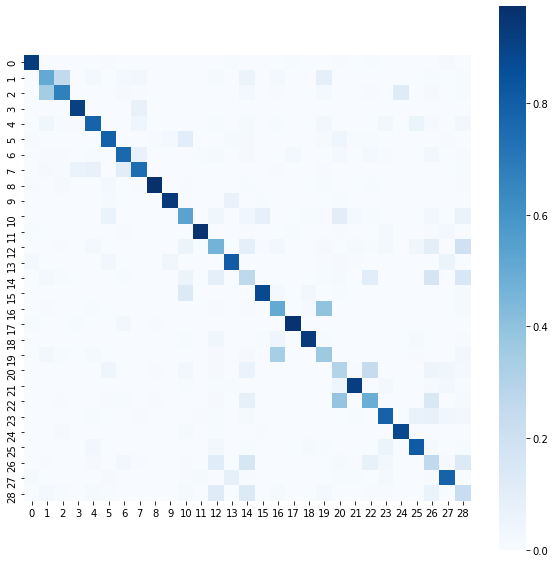

In [80]:
f, ax = plt.subplots(figsize=(10,10))
# Normalize by column-sum
sns.heatmap(cm / cm.sum(axis=0), cmap="Blues", ax=ax, square=True)

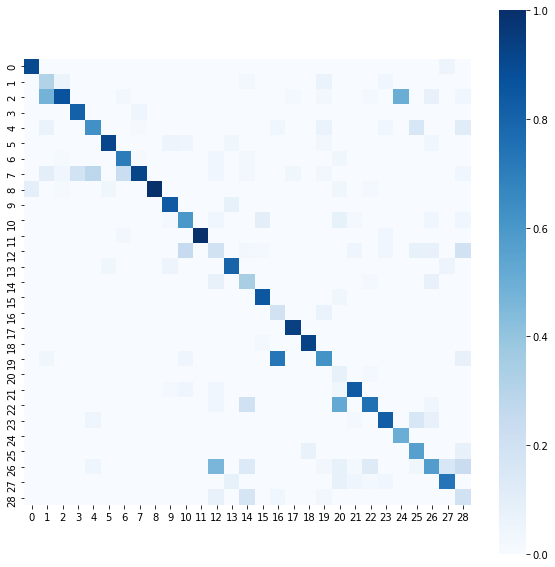

In [81]:
f, ax = plt.subplots(figsize=(10,10))
# Normalize by column-sum
sns.heatmap(valid_cm / valid_cm.sum(axis=0), cmap="Blues", ax=ax, square=True)

### get embeddings and use to calculate similarity

In [82]:
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.preprocessing import StandardScaler

In [83]:
train_embeddings = sorted(train_embeddings, key=lambda e: (e[0], e[1]))  # sort by user, walk_id

In [84]:
### Compute similarity metric on training and validation sets
user_ids, walk_ids, embeddings = zip(*train_embeddings)
embeddings = np.array(embeddings)  # (N, n_features)

In [85]:
print(embeddings.shape)
scaler = StandardScaler()
embeddings = scaler.fit_transform(embeddings)

(8343, 20)


In [86]:
multiindex = pd.MultiIndex.from_arrays([user_ids, walk_ids], names=["user_id", "walk_id"])
simi_dot = pd.DataFrame(np.dot(embeddings, embeddings.T), index=multiindex, columns=multiindex)
simi_cos = pd.DataFrame(cosine_similarity(embeddings, embeddings), index=multiindex, columns=multiindex)

In [87]:
def aggregate_similarities_mean(simi):
    # Fill in diagonals so they don't affect the aggregation
    np.fill_diagonal(simi.values, np.nan)
    pool = simi.groupby(by=["user_id", "walk_id"], axis=0).mean().groupby(by=["user_id", "walk_id"], axis=1).mean()
    return pool

### try plotting similarities using multidimensional scaling (MDS) to project into 2D

In [40]:
from sklearn.manifold import MDS

In [44]:
mds = MDS(n_components=2)

In [61]:
# Only try to fit a few users since MDS is slow
i = user_ids.index(3)
result = mds.fit_transform(embeddings[:i,:])  # Fit embeddings (n_samples, n_features)

In [62]:
mds_df = pd.DataFrame(result, index=multiindex[:i], columns=["MDSX", "MDSY"])
mds_df.head()

MDSX      MDSY
user_id walk_id                    
0       1        6.099945  3.658229
        1        3.828813  0.926085
        1        4.403554  0.670257
        1        3.814140  2.019985
        1        3.864557  0.354142

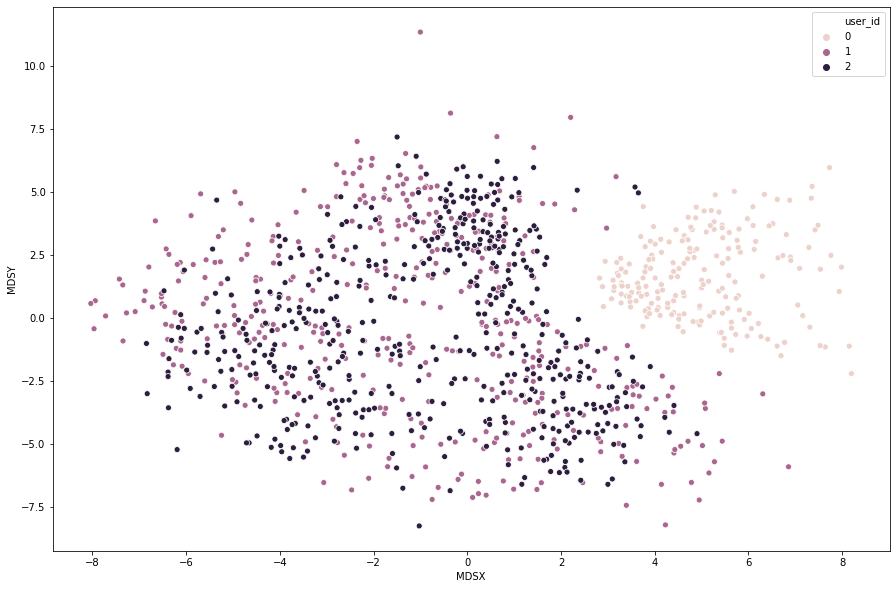

In [63]:
f, ax = plt.subplots(figsize=(15,10))
sns.scatterplot(x="MDSX", y="MDSY", hue="user_id", data=mds_df.reset_index())

### similarity heatmaps

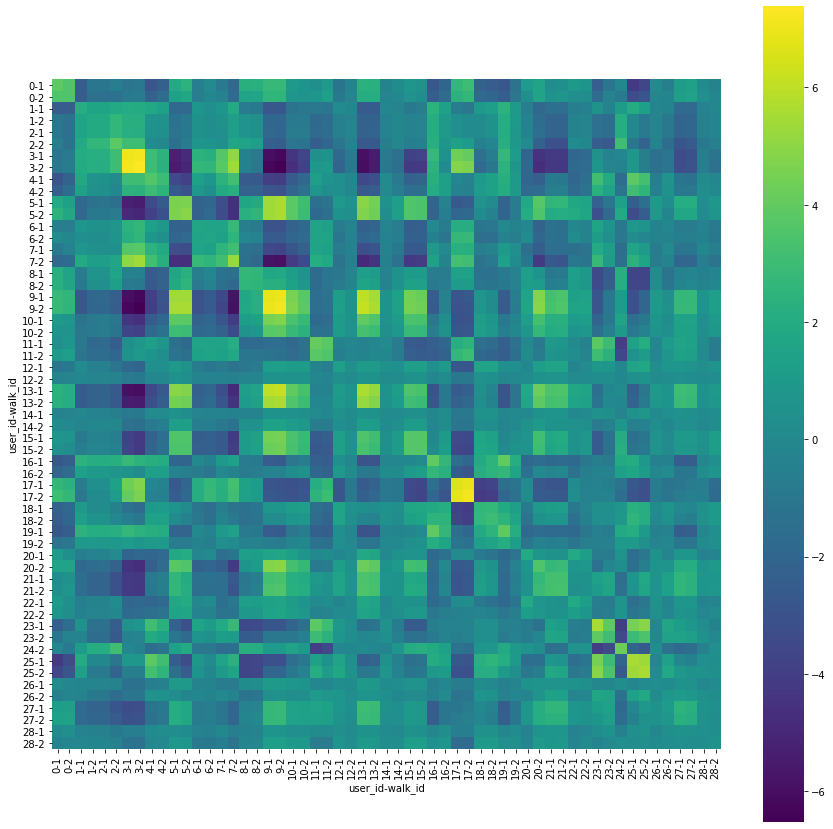

In [88]:
f, ax = plt.subplots(figsize=(15,15))
sns.heatmap(aggregate_similarities_mean(simi_dot), square=True, cmap="viridis")

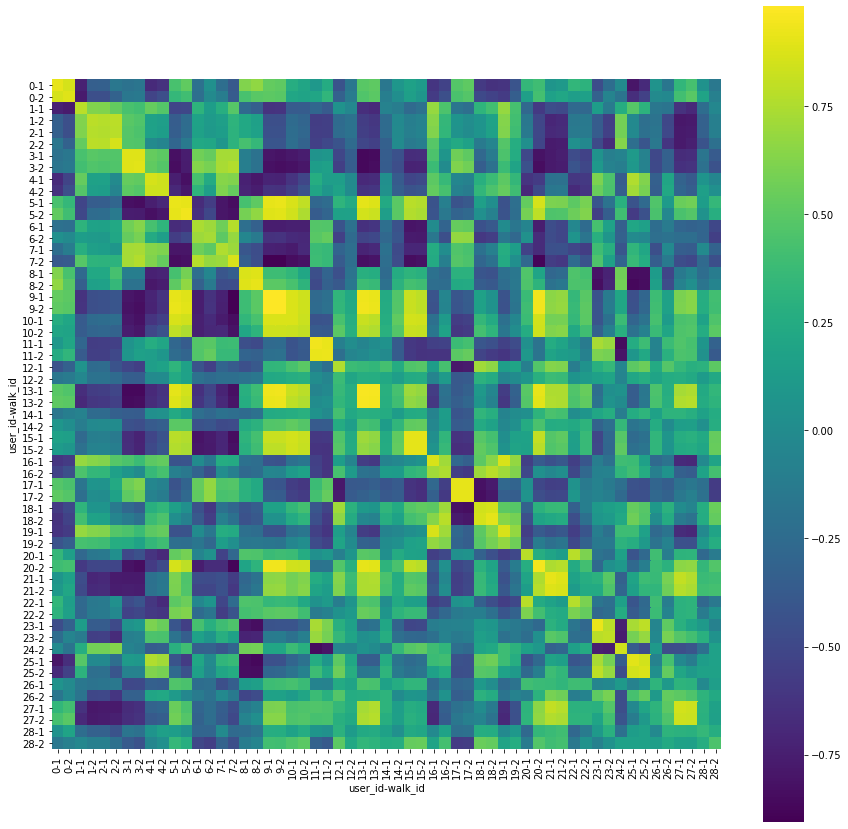

In [89]:
f, ax = plt.subplots(figsize=(15,15))
sns.heatmap(aggregate_similarities_mean(simi_cos), square=True, cmap="viridis")

In [40]:
embed_mult = np.einsum("ik,jk->ijk", embeddings, embeddings)

In [41]:
# Check that this operation performed as expected
assert all(embed_mult[0,0,:] == embeddings[0] * embeddings[0])

In [42]:
# Compute triplet loss (group embeddings by "user_ids" variable)
weight = np.ones((1,1,64)).astype(np.float32)

In [49]:
embed_mult.shape

(4181, 4181, 64)

In [57]:
import scipy.optimize
from numba import jit

In [68]:
# number of samples per user (class label)
counts = np.array([user_ids.count(user) for user in range(n_classes)])

In [76]:
# @jit(nopython=True)
def compute_triplet_loss(weight):
    triplet_loss = 0   # optimize this (maximize)
    embed_ = embed_mult * weight   # multiply weight vector into embedding matrix
    # Calculate positive distance examples (same user)
    idx_l = 0
    for user in range(n_classes):  # user is class label, need to aggregate same-class
        idx_r = idx_l + counts[user]
        user_dot_product = embed_[idx_l:idx_r, idx_l:idx_r, :].sum(axis=-1)
        triplet_loss += user_dot_product.mean() / 2  # divide by 2 since double-counting comparisons
        idx_l = idx_r + 1
    # Calculate negative distance examples (different users)
    # Do one side only here
    idx_l = 0
    for user in range(n_classes-1):  # user is class label, need to aggregate same-class
        idx_r = idx_l + counts[user]
        user_dot_product = embed_[idx_l:idx_r, idx_r:, :].sum(axis=-1)
        triplet_loss -= user_dot_product.mean()
        idx_l = idx_r + 1
    return triplet_loss

In [77]:
%%time
compute_triplet_loss(weight)

Wall time: 37.5 s


89.68719753716141

In [72]:
%%time
embed_mult *= weight

Wall time: 18.8 s
